# 평가 산식 : RMSE (회귀)

# 오늘의 목표 : EDA 및 교차검증

# 데이터 설명

id : 선수 고유의 아이디

name : 이름

age : 나이

continent : 선수들의 국적이 포함되어 있는 대륙입니다

contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다

position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등

prefer_foot : 선수가 선호하는 발입니다. ex) 오른발

reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수

stat_overall : 선수의 현재 능력치 입니다.

stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.

stat_skill_moves : 선수의 개인기 능력치 입니다.

value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다 (타겟)

In [1]:
import pandas as pd 

train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')

In [2]:
train.head(5)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [3]:
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


데이터를 간단하게 살펴보았는데 이상치와 결측값이 없는 잘 정제된 데이터이다. 

contract_until 칼럼이 숫자열인척 하는 문자열이므로 주의

# 데이터 전처리

id와 name 칼럼은 훈련에 필요하지 않으니 삭제해준다

['contract_until'] 칼럼을 int형으로 바꾸어준다

In [5]:
train = train.drop(['id','name'],axis=1)
test = test.drop(['id','name'],axis=1)

In [6]:
train.head(5)

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [7]:
train['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

['contract_until'] 칼럼을 바꿔주려고 했더니 중간에 문자열이 들어간 칼럼이 존재했다.

In [8]:
def to_numeric(x):
    if '2018' in x:
        x = 2018
    elif '2019' in x:
        x = 2019
    elif '2020' in x:
        x = 2020
    elif '2021' in x:
        x = 2021
    elif '2022' in x:
        x = 2022
    elif '2023' in x:
        x = 2023
    elif '2024' in x:
        x = 2024    
    elif '2025' in x:
        x = 2025
    elif '2026' in x:
        x = 2026   
    return x

In [9]:
train['contract_until'] = train['contract_until'].apply(lambda x : to_numeric(x))
test['contract_until'] = test['contract_until'].apply(lambda x : to_numeric(x))

전처리는 이렇게 마쳤다 잘 정제된 데이터라 처리해줄것이 없음!

# EDA

각 피처의 분포와 타겟데이터간의 상관관계를 나열해볼것이다.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# age

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='count'>

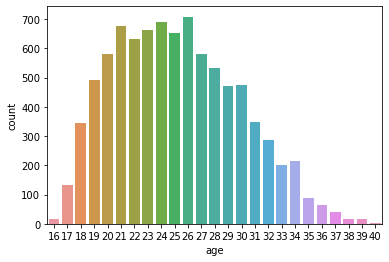

In [11]:
sns.countplot(train['age'])

seaborn의 countplot으로 나이대의 분포를 한눈에 확인할 수 있다

20~26 살의 선수들이 많고 특히 30살 이후로는 쭉쭉 떨어진다.

<AxesSubplot:xlabel='age', ylabel='value'>

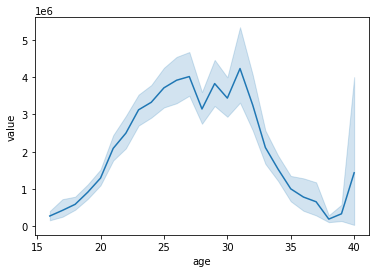

In [12]:
sns.lineplot(data=train, x='age',y='value')

seaborn의 lineplot을 이용해 두 수치형 데이터간의 상관관계를 살펴보았다

20살부터 연봉이 급격하게 오르기 시작하고 30이후로는 연봉이 급격하게 떨어진다. 

특이한점은 30후반대에 연봉이 급격하게 오르는데 편차가 매우 심한걸로 봐서는 

몇 없는 데이터 중에서 나이든 프랜차이즈 스타? 라고 추정되는 사람들의 연봉이 높아서 저런 현상이 나타난것으로 보인다.

# contitent (출신)

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='continent', ylabel='count'>

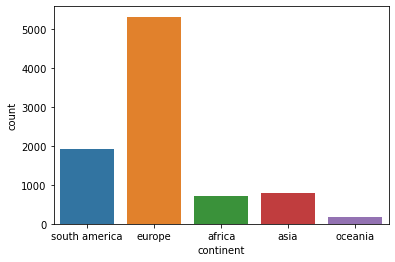

In [13]:
sns.countplot(train['continent'])

역시 축구의 본고장답게 유럽이 가장 많은 선수를 배출했고 그 뒤로 미국, 아시아, 아프리카, 오세아니아 순이다.

<AxesSubplot:xlabel='continent', ylabel='value'>

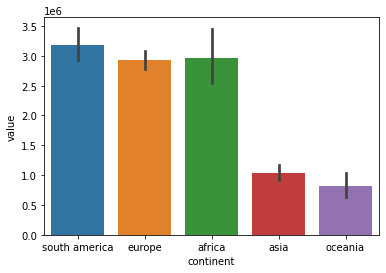

In [14]:
sns.barplot(data=train, x='continent',y='value')

seaborn의 barplot을 이용해 국가별 연봉의 평균치를 시각화해보았다

미국, 유럽, 아프리카 선수들의 연봉과 아시아, 오세아니아 선수들의 연봉이 눈에띄게 차이나는것을 볼 수 있다...

# contract_until(계약기간)

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='contract_until', ylabel='count'>

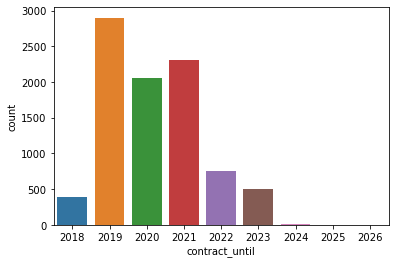

In [15]:
sns.countplot(train['contract_until'])

<AxesSubplot:xlabel='contract_until', ylabel='value'>

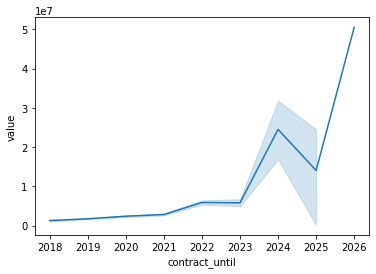

In [16]:
sns.lineplot(data=train, x='contract_until', y='value')

계약기간의 분포를 살펴보는건 별 의미없을거같아 타겟데이터와의 관계만 살펴보았다.

사실 연봉과 계약만료일은 별로 상관이 없어보인다. 

2024년 이후의 데이터는 없다고 해도 무방한 수준의 미미한 데이터이므로 몇개의 데이터가 전체 평균을 좌지우지한다.

그래도 연봉이 높아지는 이유를 뽑자면 간판스타를 놓치지 않기위해 고액의 연봉으로 다년간 계약을 성사시켰기 때문..?

# position

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='position', ylabel='count'>

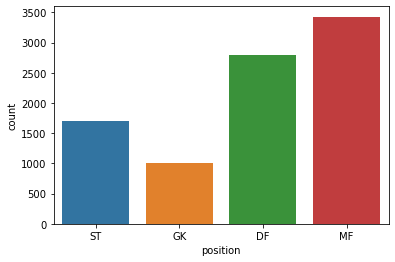

In [17]:
sns.countplot(train['position'])

ST는 공격수, GK는 골기퍼, DF는 수비수, MF는 미드필더 라고 생각한다.

미드필더>수비수>공격수>골기퍼 순으로 많다 (당연)

<AxesSubplot:xlabel='position', ylabel='value'>

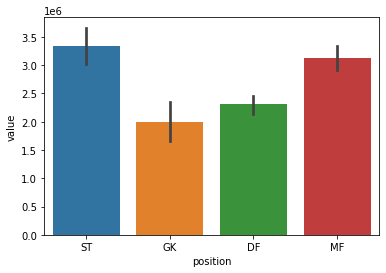

In [18]:
sns.barplot(data=train, x='position', y='value')

각 포지션별로 연봉을 살펴보니 공격수 > 미드필더 > 수비수 > 골기퍼 순으로 연봉이 높다

# prefer_foot

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prefer_foot', ylabel='count'>

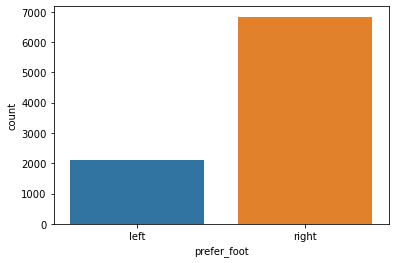

In [19]:
sns.countplot(train['prefer_foot'])

왼발잡이보다 오른발잡이가 훨씬 많다

<AxesSubplot:xlabel='prefer_foot', ylabel='value'>

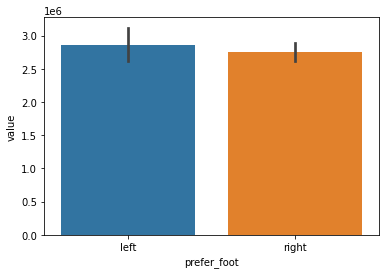

In [20]:
sns.barplot(data=train, x='prefer_foot', y='value')

거의 비슷한 수준이지만 왼발잡이의 평균연봉이 더 높다 대신 왼발잡이의 연봉편차가 더 크다.

# reputation(유명세)	

<AxesSubplot:xlabel='reputation', ylabel='value'>

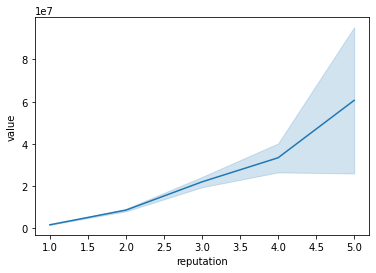

In [21]:
sns.lineplot(data=train, x='reputation', y='value')

당연하게도 유명세와 연봉은 비례한다. 그것이 유명세니까(펀쿨섹)

참고로 유명세는 숫자가 클수록 유명하고 수도 점점 적어진다

# stat_overall(능력치)

<AxesSubplot:xlabel='stat_overall', ylabel='Count'>

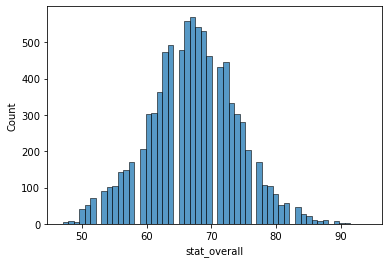

In [22]:
sns.histplot(train['stat_overall'])

seaborn의 histplot기능을 이용해 큰 범위 수치의 데이터분포를 한눈에 볼 수 있다

능력치는 정규분포 형태를 띄고 있으며 60~75 정도가 대부분을 차지하고 있다.

<AxesSubplot:xlabel='stat_overall', ylabel='value'>

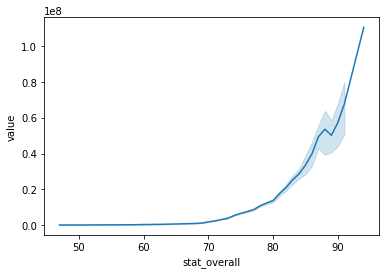

In [23]:
sns.lineplot(data=train,x='stat_overall',y='value')

능력치가 올라갈수록 연봉도 지수형태로 수직상승한다.
 
후반부에 약간 연봉이 꺾이는 부분이 있지만 80~90점대 선수들이 없다보니 데이터가 부족하여 생길 수 있는 현상이다.

# stat_potential(잠재력)	

<AxesSubplot:xlabel='stat_potential', ylabel='Count'>

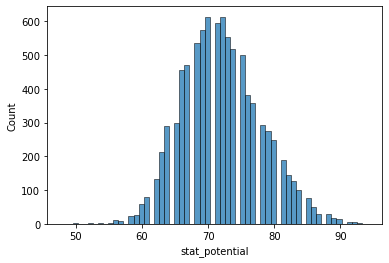

In [24]:
sns.histplot(train['stat_potential'])

잠재력 또한 정규분포의 형태를 띈다

능력치보다는 전체적으로 상향된 평균값을 보인다. 그것이 잠재력이니까.

<AxesSubplot:xlabel='stat_potential', ylabel='value'>

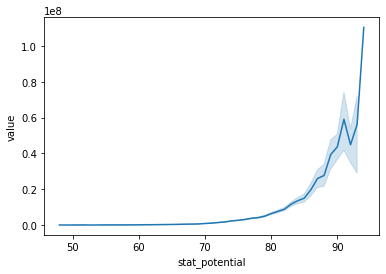

In [25]:
sns.lineplot(data=train,x='stat_potential',y='value')

잠재력 또한 능력치처럼 우상향 그래프가 보인다.

꺾이는 부분 또한 능력치와 같은 이유라고 생각한다.

# stat_skill_moves(개인기)	

C:\Users\lmj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='stat_skill_moves', ylabel='count'>

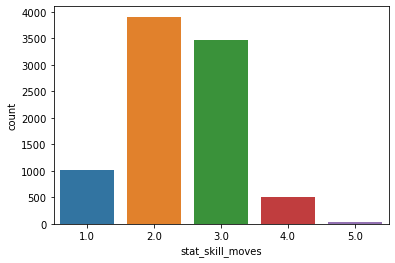

In [26]:
sns.countplot(train['stat_skill_moves'])

개인기는 평점이 2~3점인 선수가 대부분이다 

유명세와 다르게 1점인 선수들이 좀 적다

<AxesSubplot:xlabel='stat_skill_moves', ylabel='value'>

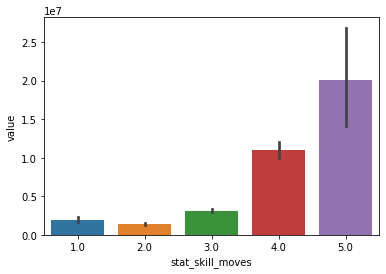

In [27]:
sns.barplot(data=train,x='stat_skill_moves',y='value')

특이하게 개인기가 1점인 선수의 연봉이 2점인 선수의 연봉보다 살짝 높다 (별차이는 없는 수준)

개인기평점이 4점이상이되면 연봉이 급격히 늘어난다.

# 인코딩

회귀이므로 레이블인코딩 대신 원핫인고딩을 해줄것이다

In [37]:
train = pd.get_dummies(train)
test= pd.get_dummies(test)

In [40]:
train

,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST,prefer_foot_left,prefer_foot_right
0,31,2021,5.0,94,94,4.0,110500000.0,0,0,0,0,1,0,0,0,1,1,0
1,27,2020,4.0,91,93,1.0,72000000.0,0,0,1,0,0,0,1,0,0,0,1
2,31,2021,5.0,91,91,3.0,80000000.0,0,0,0,0,1,0,0,0,1,0,1
3,32,2020,4.0,91,91,3.0,51000000.0,0,0,1,0,0,1,0,0,0,0,1
4,25,2021,3.0,90,93,1.0,68000000.0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,18,2019,1.0,48,63,3.0,60000.0,1,0,0,0,0,0,0,1,0,0,1
8928,19,2020,1.0,47,59,2.0,40000.0,0,0,1,0,0,1,0,0,0,0,1
8929,18,2021,1.0,47,64,2.0,50000.0,0,0,0,0,1,1,0,0,0,0,1
8930,18,2021,1.0,47,65,1.0,50000.0,0,0,1,0,0,0,1,0,0,0,1


18개의 칼럼으로 증가하였다.

# 교차검증

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
import numpy as np

In [44]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [46]:
kf = KFold(n_splits=7, shuffle=True)

X= train.drop('value',axis=1)
Y= train['value']

In [49]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model_xgb = XGBRegressor(n_estimators=500)
model_lgbm = LGBMRegressor(n_estimators=500)

valid_scores = []

for train_idx, valid_idx in kf.split(X,Y) : 
    X_tr = X.iloc[train_idx]

    y_tr = Y.iloc[train_idx]

    X_val = X.iloc[valid_idx]

    y_val = Y.iloc[valid_idx]

    model_xgb.fit(X_tr, y_tr)

    valid_prediction = model_xgb.predict(X_val)

    score = RMSE(y_val, valid_prediction)

    valid_scores.append(score)

In [50]:
print(np.mean(valid_scores))

688084.3384444413


xgb모델의 경우 688084의 수치가 나왔고

In [51]:
for train_idx, valid_idx in kf.split(X,Y) : 
    X_tr = X.iloc[train_idx]

    y_tr = Y.iloc[train_idx]

    X_val = X.iloc[valid_idx]

    y_val = Y.iloc[valid_idx]

    model_lgbm.fit(X_tr, y_tr)

    valid_prediction = model_lgbm.predict(X_val)

    score = RMSE(y_val, valid_prediction)

    valid_scores.append(score)

In [52]:
print(np.mean(valid_scores))

721334.8488145808


lgbm의 경우 721334의 값이 나왔다.

# XGB하이퍼 파라미터 튜닝

In [54]:
import optuna
from optuna import Trial, visualization

In [67]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25)

def objective(trial:Trial):
    params = {
        'objective' : 'reg:squarederror',
        'eval_metric' : 'rmse',
        'learning_rate' : trial.suggest_float('learning_rate',0.01,0.2),
        'n_estimators' : trial.suggest_int('n_estimators',100,5000),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,250),
        'min_split_loss' : trial.suggest_int('min_split_loss',1,5),
        'max_depth' : trial.suggest_int('max_depth',3,10),
        'subsample' : trial.suggest_float('subsample',0.5,1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree',0.1,1),
        'reg_lambda' : trial.suggest_float('reg_lambda',0,1),
        'reg_alpha' : trial.suggest_float('reg_alpha',0,1)
    }
    
    model = XGBRegressor(**params)
    xgb_model = model.fit(x_train,y_train)
    xgb_pred = model.predict(x_test)
    score = RMSE(y_test, xgb_pred)
    
    return score

In [69]:
from optuna.samplers import TPESampler
study = optuna.create_study(direction='minimize',sampler = TPESampler())
study.optimize(objective, n_trials=25)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-03-23 17:58:58,778] A new study created in memory with name: no-name-5f070bac-e6a6-45cf-8e0f-5797f5b121e7
[I 2022-03-23 17:59:13,212] Trial 0 finished with value: 1209995.5413235012 and parameters: {'learning_rate': 0.06970915707814836, 'n_estimators': 3131, 'min_child_weight': 126, 'min_split_loss': 4, 'max_depth': 10, 'subsample': 0.8407363915967812, 'colsample_bytree': 0.8369320351858048, 'reg_lambda': 0.7846934373002048, 'reg_alpha': 0.6356534280823722}. Best is trial 0 with value: 1209995.5413235012.
[I 2022-03-23 17:59:29,872] Trial 1 finished with value: 892516.7476488057 and parameters: {'learning_rate': 0.14178438582205857, 'n_estimators': 3302, 'min_child_weight': 24, 'min_split_loss': 2, 'max_depth': 7, 'subsample': 0.9310033080822646, 'colsample_bytree': 0.9741346946175375, 'reg_lambda': 0.40649274619610587, 'reg_alpha': 0.14696982799479763}. Best is trial 1 with value: 892516.7476488057.
[I 2022-03-23 17:59:41,926] Trial 2 finished with value: 2065929.7376525928 an

Best Score: 803949.1652462101
Best trial: {'learning_rate': 0.16156979566661384, 'n_estimators': 2152, 'min_child_weight': 22, 'min_split_loss': 3, 'max_depth': 8, 'subsample': 0.65396865423753, 'colsample_bytree': 0.47925325295335014, 'reg_lambda': 0.13147234504084365, 'reg_alpha': 0.1821504010734501}


In [72]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(X,Y,eval_metric='rmse')
pred_xgb=xgb.predict(test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

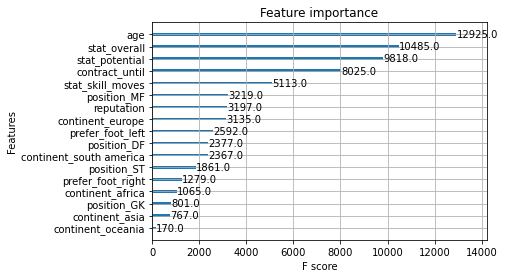

In [73]:
from xgboost import plot_importance
plot_importance(xgb)

모델 훈련과 예측을 해본 뒤 피쳐 중요도를 살펴보았다.

나이 능력치 잠재력이 연봉에 큰 영향을 끼치는것을 알 수 있다.

#  LGBM 하이퍼 파라미터 튜닝

In [78]:
def objective_1(trial:Trial):
    params = {
        'objective' : 'regression',
        'eval_metric' : 'rmse',
        'learning_rate' : trial.suggest_float('learning_rate',0.01,0.2),
        'n_estimators' : trial.suggest_int('n_estimators',100,5000),
        'min_child_samples' : trial.suggest_int('min_child_samples',1,256),
        'num_leaves' : trial.suggest_int('num_leaves',1,128),
        'max_depth' : trial.suggest_int('max_depth',1,64),
        'subsample' : trial.suggest_float('subsample',0.5,1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree',0.1,1),
        'reg_lambda' : trial.suggest_float('reg_lambda',0,1),
        'reg_alpha' : trial.suggest_float('reg_alpha',0,1)
    }
    
    model = LGBMRegressor(**params)
    lgbm_model = model.fit(x_train,y_train)
    lgbm_pred = model.predict(x_test)
    score = RMSE(y_test, lgbm_pred)
    
    return score

In [79]:
from optuna.samplers import TPESampler
study = optuna.create_study(direction='minimize',sampler = TPESampler())
study.optimize(objective_1, n_trials=25)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-03-23 18:17:52,421] A new study created in memory with name: no-name-24307742-2cb4-4fab-a8d3-16130e478d49
[I 2022-03-23 18:17:54,035] Trial 0 finished with value: 1039839.0132125843 and parameters: {'learning_rate': 0.11370238305577549, 'n_estimators': 4570, 'min_child_samples': 125, 'num_leaves': 5, 'max_depth': 33, 'subsample': 0.5787787483013358, 'colsample_bytree': 0.9291801860127418, 'reg_lambda': 0.2628580730608401, 'reg_alpha': 0.15594790985301643}. Best is trial 0 with value: 1039839.0132125843.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:17:55,041] Trial 1 finished with value: 884465.768852847 and parameters: {'learning_rate': 0.18399670087695078, 'n_estimators': 1783, 'min_child_samples': 3, 'num_leaves': 25, 'max_depth': 7, 'subsample': 0.9735367095014087, 'colsample_bytree': 0.1395354651730557, 'reg_lambda': 0.04904975574020687, 'reg_alpha': 0.42348083314083085}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:17:58,025] Trial 2 finished with value: 1460002.3771167167 and parameters: {'learning_rate': 0.02423780006150014, 'n_estimators': 2619, 'min_child_samples': 184, 'num_leaves': 87, 'max_depth': 43, 'subsample': 0.7310894761675691, 'colsample_bytree': 0.7597865295486854, 'reg_lambda': 0.7581788461208995, 'reg_alpha': 0.9432676060662569}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:00,726] Trial 3 finished with value: 1699843.3135873587 and parameters: {'learning_rate': 0.029875735070007445, 'n_estimators': 4584, 'min_child_samples': 189, 'num_leaves': 35, 'max_depth': 6, 'subsample': 0.8192852539372559, 'colsample_bytree': 0.9741094672422396, 'reg_lambda': 0.0010330977603493219, 'reg_alpha': 0.20105171793739873}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:02,177] Trial 4 finished with value: 1265180.895597936 and parameters: {'learning_rate': 0.1748920899463318, 'n_estimators': 1103, 'min_child_samples': 160, 'num_leaves': 108, 'max_depth': 46, 'subsample': 0.9973779778736698, 'colsample_bytree': 0.5198988976976298, 'reg_lambda': 0.45280223113061113, 'reg_alpha': 0.2396553127615606}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:03,213] Trial 5 finished with value: 1745502.667242213 and parameters: {'learning_rate': 0.1977988776342883, 'n_estimators': 4242, 'min_child_samples': 122, 'num_leaves': 26, 'max_depth': 1, 'subsample': 0.9932229541491657, 'colsample_bytree': 0.4481313598108063, 'reg_lambda': 0.3672428479046058, 'reg_alpha': 0.5486010536158948}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:06,446] Trial 6 finished with value: 1793785.022335346 and parameters: {'learning_rate': 0.0638568188527265, 'n_estimators': 3155, 'min_child_samples': 199, 'num_leaves': 68, 'max_depth': 54, 'subsample': 0.6248094141566279, 'colsample_bytree': 0.46725285049480014, 'reg_lambda': 0.8562289392242588, 'reg_alpha': 0.8225851018080683}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:08,161] Trial 7 finished with value: 1354979.0345166354 and parameters: {'learning_rate': 0.13993031115008941, 'n_estimators': 1362, 'min_child_samples': 166, 'num_leaves': 120, 'max_depth': 40, 'subsample': 0.6346871900631779, 'colsample_bytree': 0.8940725924510581, 'reg_lambda': 0.48990174615197846, 'reg_alpha': 0.0822251535265196}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:08,908] Trial 8 finished with value: 1252686.4479040413 and parameters: {'learning_rate': 0.18687002617256762, 'n_estimators': 932, 'min_child_samples': 136, 'num_leaves': 15, 'max_depth': 53, 'subsample': 0.6514234267500016, 'colsample_bytree': 0.6031021029570389, 'reg_lambda': 0.5469165606237395, 'reg_alpha': 0.27944818730863596}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:09,559] Trial 9 finished with value: 2188267.043792175 and parameters: {'learning_rate': 0.10589571228590527, 'n_estimators': 2638, 'min_child_samples': 205, 'num_leaves': 2, 'max_depth': 16, 'subsample': 0.5012179660470926, 'colsample_bytree': 0.8586223507077438, 'reg_lambda': 0.5810593607903988, 'reg_alpha': 0.6359398431721442}. Best is trial 1 with value: 884465.768852847.
[I 2022-03-23 18:18:09,811] Trial 10 finished with value: 1288901.2892770208 and parameters: {'learning_rate': 0.14909208351697634, 'n_estimators': 191, 'min_child_samples': 9, 'num_leaves': 59, 'max_depth': 20, 'subsample': 0.8794681018775202, 'colsample_bytree': 0.10305349920875476, 'reg_lambda': 0.05816366897391243, 'reg_alpha': 0.3962889815216762}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:13,114] Trial 11 finished with value: 929875.969722906 and parameters: {'learning_rate': 0.09911863867111953, 'n_estimators': 3520, 'min_child_samples': 23, 'num_leaves': 39, 'max_depth': 28, 'subsample': 0.5028490005751174, 'colsample_bytree': 0.10371722636176735, 'reg_lambda': 0.21073039154668533, 'reg_alpha': 0.03485060561346254}. Best is trial 1 with value: 884465.768852847.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:16,384] Trial 12 finished with value: 711612.7970023954 and parameters: {'learning_rate': 0.06320520909188412, 'n_estimators': 3197, 'min_child_samples': 5, 'num_leaves': 43, 'max_depth': 21, 'subsample': 0.9070251335904914, 'colsample_bytree': 0.10991660571324292, 'reg_lambda': 0.18324016021181852, 'reg_alpha': 0.4287060339900426}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:20,616] Trial 13 finished with value: 1009938.4028561928 and parameters: {'learning_rate': 0.062118643480672114, 'n_estimators': 2016, 'min_child_samples': 57, 'num_leaves': 54, 'max_depth': 13, 'subsample': 0.8999450929005219, 'colsample_bytree': 0.28494386763011853, 'reg_lambda': 0.1576944725515465, 'reg_alpha': 0.394804869315501}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:26,882] Trial 14 finished with value: 976979.7010276169 and parameters: {'learning_rate': 0.07113006843654288, 'n_estimators': 3579, 'min_child_samples': 63, 'num_leaves': 45, 'max_depth': 27, 'subsample': 0.9215303956279596, 'colsample_bytree': 0.2612762724735542, 'reg_lambda': 0.08746536075158794, 'reg_alpha': 0.6388700513884511}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:29,450] Trial 15 finished with value: 979327.5405581142 and parameters: {'learning_rate': 0.1350733629040835, 'n_estimators': 1923, 'min_child_samples': 63, 'num_leaves': 75, 'max_depth': 9, 'subsample': 0.7863084132213958, 'colsample_bytree': 0.24609987226366847, 'reg_lambda': 0.25030664404012914, 'reg_alpha': 0.44262752903636465}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:31,986] Trial 16 finished with value: 873105.4566941571 and parameters: {'learning_rate': 0.08574517892739181, 'n_estimators': 1949, 'min_child_samples': 32, 'num_leaves': 23, 'max_depth': 19, 'subsample': 0.9270657164830883, 'colsample_bytree': 0.34697223597123994, 'reg_lambda': 0.33212881406024863, 'reg_alpha': 0.7269000805908954}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:42,553] Trial 17 finished with value: 793895.1795770407 and parameters: {'learning_rate': 0.08266834086054022, 'n_estimators': 3083, 'min_child_samples': 36, 'num_leaves': 86, 'max_depth': 63, 'subsample': 0.8455072896943149, 'colsample_bytree': 0.3912745380648445, 'reg_lambda': 0.3817833552128431, 'reg_alpha': 0.8577248100056853}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:47,236] Trial 18 finished with value: 1800911.054201025 and parameters: {'learning_rate': 0.042990976733820574, 'n_estimators': 3964, 'min_child_samples': 238, 'num_leaves': 103, 'max_depth': 62, 'subsample': 0.8473005594142617, 'colsample_bytree': 0.6455251131334407, 'reg_lambda': 0.3921396246452258, 'reg_alpha': 0.9506945603869204}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:18:57,713] Trial 19 finished with value: 1007268.3361882855 and parameters: {'learning_rate': 0.04692136362533233, 'n_estimators': 4999, 'min_child_samples': 92, 'num_leaves': 86, 'max_depth': 62, 'subsample': 0.7373880033387947, 'colsample_bytree': 0.3984880942232405, 'reg_lambda': 0.6545197160671667, 'reg_alpha': 0.8194086040797844}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:19:02,081] Trial 20 finished with value: 1323238.5098166964 and parameters: {'learning_rate': 0.012760862921177632, 'n_estimators': 3042, 'min_child_samples': 94, 'num_leaves': 85, 'max_depth': 35, 'subsample': 0.7906520226819265, 'colsample_bytree': 0.17866961725912683, 'reg_lambda': 0.9813520031965901, 'reg_alpha': 0.31944958542891677}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:19:07,334] Trial 21 finished with value: 762062.8212248258 and parameters: {'learning_rate': 0.08988404498639518, 'n_estimators': 2331, 'min_child_samples': 36, 'num_leaves': 50, 'max_depth': 22, 'subsample': 0.9384552688310388, 'colsample_bytree': 0.39148798201424007, 'reg_lambda': 0.33376897197818745, 'reg_alpha': 0.7470452733134869}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:19:14,356] Trial 22 finished with value: 802647.0190436457 and parameters: {'learning_rate': 0.0840165232624708, 'n_estimators': 2985, 'min_child_samples': 37, 'num_leaves': 48, 'max_depth': 25, 'subsample': 0.9447572560778894, 'colsample_bytree': 0.34650183820522507, 'reg_lambda': 0.31716849490973303, 'reg_alpha': 0.8220967091897773}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:19:20,730] Trial 23 finished with value: 976966.2829787193 and parameters: {'learning_rate': 0.0851242001662743, 'n_estimators': 2389, 'min_child_samples': 86, 'num_leaves': 67, 'max_depth': 22, 'subsample': 0.8603070935297177, 'colsample_bytree': 0.6966517090638416, 'reg_lambda': 0.14724122317295132, 'reg_alpha': 0.5293485003351364}. Best is trial 12 with value: 711612.7970023954.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-03-23 18:19:32,239] Trial 24 finished with value: 916133.9269366123 and parameters: {'learning_rate': 0.12123073761831288, 'n_estimators': 3435, 'min_child_samples': 44, 'num_leaves': 74, 'max_depth': 37, 'subsample': 0.9501003573072382, 'colsample_bytree': 0.5597170687050789, 'reg_lambda': 0.45434431320601143, 'reg_alpha': 0.7149899931115737}. Best is trial 12 with value: 711612.7970023954.


Best Score: 711612.7970023954
Best trial: {'learning_rate': 0.06320520909188412, 'n_estimators': 3197, 'min_child_samples': 5, 'num_leaves': 43, 'max_depth': 21, 'subsample': 0.9070251335904914, 'colsample_bytree': 0.10991660571324292, 'reg_lambda': 0.18324016021181852, 'reg_alpha': 0.4287060339900426}


In [82]:
lgbm = LGBMRegressor(**study.best_params)
lgbm.fit(X,Y,eval_metric='rmse')
pred_lgbm=lgbm.predict(test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

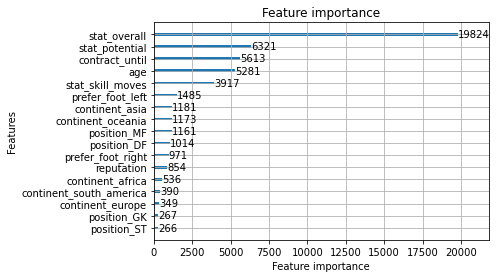

In [83]:
from lightgbm import plot_importance
plot_importance(lgbm)

lgbm에서는 능력치가 엄청나게 중요한 피쳐라고 보여주었다.

# 최종

In [84]:
pred = (pred_xgb + pred_lgbm)/2

In [86]:
sub = pd.read_csv('submission.csv')

In [88]:
sub['value']=pred

In [89]:
sub.to_csv('1.csv', index = False)

제출결과 948247점으로 퍼블릭 148등

---

추가적으로 공유된 코드를 살펴보았는데 타켓값인 value를 로그변환시켜 훈련해준 뒤 다시 원래대로 돌려놓는 까먹고있었던 방식을 사용했는데
결과가 아주 좋아보였다. 

선수간 연봉 편차가 되게 크고 정규분포형태가 아니였는데 타켓값을 로그변환시켜주면 훨씬 정확한 예측을 할 수 있었을것 같다. 좋은 방법!